In [1]:
# ANÁLISIS NO SUPERVISADO

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [2]:
# 3) Clustering Samsung

df_samsung = pd.read_csv('samsung.csv')
X_sam = df_samsung[['Close', 'Volume']]
scaler_sam = StandardScaler()
X_sam_scaled = scaler_sam.fit_transform(X_sam)

In [3]:
# Determinar k óptimo con Silhouette Score
inertia, sil_scores = [], []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sam_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sam_scaled, kmeans.labels_))

best_k = K_range[sil_scores.index(max(sil_scores))]
silhouette = max(sil_scores)
print(f"Mejor k según Silhouette: {best_k}, Silhouette Score: {silhouette:.4f}")

Mejor k según Silhouette: 3, Silhouette Score: 0.5013


In [4]:
# Modelo final
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
df_samsung['Cluster'] = kmeans_best.fit_predict(X_sam_scaled)

In [5]:
# Guardar modelo
joblib.dump(kmeans_best, 'artifacts/modelo_kmeans_samsung.joblib')

['artifacts/modelo_kmeans_samsung.joblib']

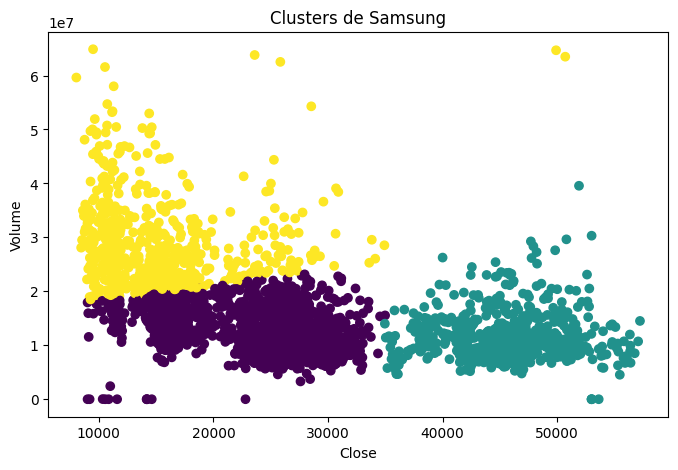

In [6]:
# Gráfico clusters
fig1_path = 'artifacts/samsung_clusters.png'
plt.figure(figsize=(8,5))
plt.scatter(df_samsung['Close'], df_samsung['Volume'], c=df_samsung['Cluster'], cmap='viridis')
plt.xlabel('Close')
plt.ylabel('Volume')
plt.title('Clusters de Samsung')
plt.savefig(fig1_path)
plt.show()

In [7]:
# 4) PCA Comprar vs Alquilar

df_compra = pd.read_csv('comprar_alquilar.csv')
X_compra = df_compra.drop(columns=['comprar'])

cat_cols = X_compra.select_dtypes(include=['object']).columns.tolist()
num_cols = X_compra.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

pca_pipe = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=2))
])

X_pca = pca_pipe.fit_transform(X_compra)

In [8]:
# Guardar modelo PCA
joblib.dump(pca_pipe, 'artifacts/modelo_pca_comprar_alquilar.joblib')

['artifacts/modelo_pca_comprar_alquilar.joblib']

In [9]:
# Crear DataFrame con componentes
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['comprar'] = df_compra['comprar']

In [10]:
# Varianza explicada
var_pc1 = pca_pipe.named_steps['pca'].explained_variance_ratio_[0]
var_pc2 = pca_pipe.named_steps['pca'].explained_variance_ratio_[1]
var_total = var_pc1 + var_pc2
print(f"Varianza explicada PC1: {var_pc1:.2%}, PC2: {var_pc2:.2%}, Total: {var_total:.2%}")

Varianza explicada PC1: 29.91%, PC2: 23.29%, Total: 53.21%


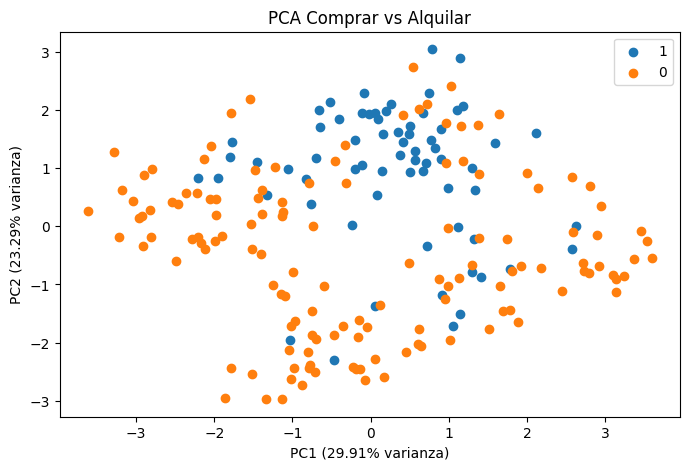

In [11]:
# Gráfico PCA
fig2_path = 'artifacts/comprar_alquilar_pca.png'
plt.figure(figsize=(8,5))
for label in df_pca['comprar'].unique():
    subset = df_pca[df_pca['comprar'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label)
plt.xlabel(f'PC1 ({var_pc1:.2%} varianza)')
plt.ylabel(f'PC2 ({var_pc2:.2%} varianza)')
plt.title('PCA Comprar vs Alquilar')
plt.legend()
plt.savefig(fig2_path)
plt.show()